# 🎓 Aula 3: Orquestração de Estado com LangGraph

## Performance – IA para Devs | Desenvolvimento e Orquestração de Agentes de IA para o Setor Financeiro

---

### 📋 Objetivos desta Aula

Ao final desta aula, você será capaz de:

1. **Compreender Grafos Computacionais**: Nós (Nodes) e Arestas (Edges)
2. **Implementar Gerenciamento de Estado Global** em fluxos complexos
3. **Criar fluxos não-lineares e cíclicos** de decisão
4. **Implementar persistência de memória** com Checkpoints
5. **Desenvolver Human-in-the-Loop** para aprovações críticas
6. **Construir o projeto "O Motor de Decisão"**: Fluxo de aprovação de crédito

---

### 🛠️ Stack Tecnológico

- **Python 3.10+**
- **LangGraph** - Framework para grafos de estado com LLMs
- **LangChain Core** - Integração com modelos
- **Pydantic** - Definição de estados tipados

---

### 📚 Pré-requisitos

- Ter completado as **Aulas 1 e 2**
- Entendimento de **Agentes e Ferramentas**
- Familiaridade com **extração estruturada**

---

## 🚀 Parte 0: Configuração do Ambiente

Vamos instalar o LangGraph e suas dependências.

In [ ]:
# Instalação das dependências necessárias

%pip install langgraph langchain langchain-openai langchain-core --quiet
%pip install pydantic python-dotenv --quiet

In [ ]:
# Configuração das variáveis de ambiente

import os
from dotenv import load_dotenv

load_dotenv()

if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = "-"  # Substitua pela sua chave

print("✅ Ambiente configurado com sucesso!")


---

## 📚 Parte 1: Introdução a Grafos Computacionais

### 1.1 Por que Grafos?

Até agora, trabalhamos com:
- **Chains lineares**: A → B → C → D (sequencial)
- **Agentes**: Decidem qual ferramenta usar, mas sem estado persistente

**Problemas em cenários complexos:**
- Como voltar a um passo anterior se algo der errado?
- Como pausar e aguardar aprovação humana?
- Como manter estado entre múltiplas interações?

### 1.2 Grafos Resolvem Isso!

```
┌─────────────────────────────────────────────────────────────────────────┐
│                         FLUXO DE APROVAÇÃO DE CRÉDITO                    │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│                        ┌──────────────┐                                  │
│                        │   INÍCIO     │                                  │
│                        └──────┬───────┘                                  │
│                               │                                          │
│                               ▼                                          │
│                   ┌───────────────────────┐                              │
│                   │  Coletar Dados        │                              │
│                   │  do Cliente           │                              │
│                   └───────────┬───────────┘                              │
│                               │                                          │
│                               ▼                                          │
│                   ┌───────────────────────┐                              │
│                   │  Calcular Score       │                              │
│                   │  de Risco             │                              │
│                   └───────────┬───────────┘                              │
│                               │                                          │
│                               ▼                                          │
│                   ┌───────────────────────┐                              │
│            ┌──────│  Avaliar Risco        │──────┐                       │
│            │      └───────────────────────┘      │                       │
│            │                 │                   │                       │
│     BAIXO  │          MÉDIO  │                   │  ALTO                 │
│            ▼                 ▼                   ▼                       │
│    ┌──────────────┐  ┌──────────────┐   ┌──────────────┐                 │
│    │  Aprovar     │  │  HUMAN-IN-   │   │  Rejeitar    │                 │
│    │  Automático  │  │  THE-LOOP    │   │  Automático  │                 │
│    └──────┬───────┘  │  (Aguardar)  │   └──────┬───────┘                 │
│           │          └──────┬───────┘          │                         │
│           │                 │                  │                         │
│           │        ┌────────┴────────┐         │                         │
│           │   APROVA│               │REJEITA   │                         │
│           │        ▼                ▼          │                         │
│           │   ┌─────────┐      ┌─────────┐     │                         │
│           └──▶│ Gerar   │      │Solicitar│◀────┘                         │
│               │Contrato │      │Docs Adicionais│──────┐                  │
│               └────┬────┘      └─────────┘     │      │                  │
│                    │                           │      │                  │
│                    ▼                           │      │                  │
│               ┌─────────┐                      │      │                  │
│               │   FIM   │◀─────────────────────┘      │                  │
│               └─────────┘                             │                  │
│                    ▲                                  │                  │
│                    └──────────────────────────────────┘                  │
│                         (Reprocessar após novos docs)                    │
│                                                                          │
└─────────────────────────────────────────────────────────────────────────┘
```

### 1.3 Conceitos Fundamentais do LangGraph

| Conceito | Descrição | Exemplo |
|----------|-----------|--------|
| **State** | Dados que fluem pelo grafo | `{"cliente": {...}, "risco": "MÉDIO"}` |
| **Node** | Função que processa/modifica o estado | `calcular_risco()` |
| **Edge** | Conexão entre nós | `coletar_dados` → `calcular_risco` |
| **Conditional Edge** | Decisão de roteamento | Se risco == "ALTO" → rejeitar |
| **Checkpoint** | Persistência do estado | Salvar estado para retomar depois |

---

In [48]:
# Exemplo básico: Entendendo o conceito de Estado

from typing import TypedDict, Annotated, Literal
from langgraph.graph import StateGraph, END, START
import operator

# Definição do Estado - o que flui pelo grafo
class EstadoSimples(TypedDict):
    """Estado que flui pelo grafo."""
    contador: int
    mensagens: Annotated[list[str], operator.add]  # Acumula mensagens

# Funções dos Nós
def incrementar(state: EstadoSimples) -> EstadoSimples:
    """Incrementa o contador."""
    print(f"   📍 Nó 'incrementar': contador = {state['contador']} → {state['contador'] + 1}")
    return {
        "contador": state["contador"] + 1,
        "mensagens": [f"Incrementado para {state['contador'] + 1}"]
    }

def dobrar(state: EstadoSimples) -> EstadoSimples:
    """Dobra o contador."""
    print(f"   📍 Nó 'dobrar': contador = {state['contador']} → {state['contador'] * 2}")
    return {
        "contador": state["contador"] * 2,
        "mensagens": [f"Dobrado para {state['contador'] * 2}"]
    }

def verificar(state: EstadoSimples) -> EstadoSimples:
    """Verifica o estado final."""
    print(f"   📍 Nó 'verificar': contador final = {state['contador']}")
    return {
    "mensagens": [f"Verificação concluída. Valor final: {state['contador']}"],
    "contador": state['contador']  # Include the required field
}

# Construindo o Grafo
grafo_simples = StateGraph(EstadoSimples)

# Adiciona os nós
grafo_simples.add_node("incrementar", incrementar)
grafo_simples.add_node("dobrar", dobrar)
grafo_simples.add_node("verificar", verificar)

# Define as arestas (fluxo)
grafo_simples.add_edge(START, "incrementar")  # Começa incrementando
grafo_simples.add_edge("incrementar", "dobrar")  # Depois dobra
grafo_simples.add_edge("dobrar", "verificar")  # Depois verifica
grafo_simples.add_edge("verificar", END)  # Termina

# Compila o grafo
app_simples = grafo_simples.compile()

print("✅ Grafo simples criado!")
print("   Fluxo: START → incrementar → dobrar → verificar → END")

✅ Grafo simples criado!
   Fluxo: START → incrementar → dobrar → verificar → END


### 1.3 Visualizando o Grafo Simples

Agora vamos ver o grafo que criamos de forma visual!

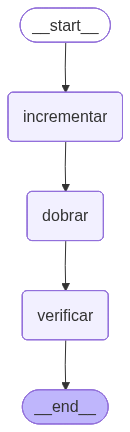


Este é um grafo LINEAR: __start__ → incrementar → dobrar → verificar → __end__
Cada nó executa em sequência, sem ramificações.



In [49]:
# Visualizando o Grafo Simples

from IPython.display import Image, display

drawing_simples = app_simples.get_graph().draw_mermaid_png()
display(Image(drawing_simples))

print("""
Este é um grafo LINEAR: __start__ → incrementar → dobrar → verificar → __end__
Cada nó executa em sequência, sem ramificações.
""")

### 1.4 Executando o Grafo: O Método `.invoke()`

Após compilar o grafo, você precisa **executá-lo** passando um estado inicial. O método `.invoke()` é responsável por:

1. **Receber o estado inicial** (um dicionário com os valores de partida)
2. **Processar cada nó** na ordem definida pelas arestas
3. **Acumular mudanças** no estado conforme cada nó retorna seu output
4. **Retornar o estado final** com todas as transformações aplicadas

**Conceito-chave:** O estado que você passa não é modificado diretamente. Cada nó recebe uma cópia do estado atual e retorna apenas os campos que quer atualizar. O LangGraph faz o merge automaticamente.

In [50]:
# Executando o grafo simples

# Estado inicial - o ponto de partida
estado_inicial = {
    "contador": 5,
    "mensagens": ["Início da execução"]
}

print(f"ENTRADA: contador = {estado_inicial['contador']}")
print(f"ESPERADO: (5+1)*2 = 12\n")

# Executa o grafo
resultado = app_simples.invoke(estado_inicial)

print(f"\nSAÍDA: contador = {resultado['contador']}")
print(f"\nHistórico de transformações:")
for msg in resultado['mensagens']:
    print(f"  → {msg}")

ENTRADA: contador = 5
ESPERADO: (5+1)*2 = 12

   📍 Nó 'incrementar': contador = 5 → 6
   📍 Nó 'dobrar': contador = 6 → 12
   📍 Nó 'verificar': contador final = 12

SAÍDA: contador = 12

Histórico de transformações:
  → Início da execução
  → Incrementado para 6
  → Dobrado para 12
  → Verificação concluída. Valor final: 12


---

## 📚 Parte 2: Arestas Condicionais (Conditional Edges)

Arestas condicionais permitem que o fluxo tome **diferentes caminhos** baseado no estado atual.

Isso é fundamental para decisões de negócio!

In [51]:
# Exemplo com Arestas Condicionais

from typing import TypedDict, Annotated, Literal
from langgraph.graph import StateGraph, END, START
import operator

# Estado para decisão de crédito simplificada
class EstadoDecisao(TypedDict):
    """Estado para decisão de crédito."""
    nome_cliente: str
    score: int
    decisao: str
    motivo: str
    historico: Annotated[list[str], operator.add]

# Nó: Analisar Score
def analisar_score(state: EstadoDecisao) -> dict:
    """Analisa o score e prepara para decisão."""
    score = state["score"]
    print(f"   📊 Analisando score de {state['nome_cliente']}: {score}")
    
    return {
        "historico": [f"Score {score} analisado"]
    }

# Nó: Aprovar
def aprovar(state: EstadoDecisao) -> dict:
    """Aprova o crédito."""
    print(f"   ✅ Crédito APROVADO para {state['nome_cliente']}")
    return {
        "decisao": "APROVADO",
        "motivo": f"Score {state['score']} acima do mínimo (700)",
        "historico": ["Decisão: APROVADO"]
    }

# Nó: Revisar
def revisar(state: EstadoDecisao) -> dict:
    """Envia para revisão humana."""
    print(f"   ⚠️ Crédito enviado para REVISÃO - {state['nome_cliente']}")
    return {
        "decisao": "EM_REVISAO",
        "motivo": f"Score {state['score']} requer análise manual (entre 500-699)",
        "historico": ["Decisão: ENVIADO PARA REVISÃO"]
    }

# Nó: Rejeitar
def rejeitar(state: EstadoDecisao) -> dict:
    """Rejeita o crédito."""
    print(f"   ❌ Crédito REJEITADO para {state['nome_cliente']}")
    return {
        "decisao": "REJEITADO",
        "motivo": f"Score {state['score']} abaixo do mínimo (500)",
        "historico": ["Decisão: REJEITADO"]
    }

# Função de roteamento condicional
def rotear_por_score(state: EstadoDecisao) -> Literal["aprovar", "revisar", "rejeitar"]:
    """Decide qual caminho seguir baseado no score."""
    score = state["score"]
    
    if score >= 700:
        return "aprovar"
    elif score >= 500:
        return "revisar"
    else:
        return "rejeitar"

# Construindo o Grafo
grafo_decisao = StateGraph(EstadoDecisao)

# Adiciona nós
grafo_decisao.add_node("analisar_score", analisar_score)
grafo_decisao.add_node("aprovar", aprovar)
grafo_decisao.add_node("revisar", revisar)
grafo_decisao.add_node("rejeitar", rejeitar)

# Aresta inicial
grafo_decisao.add_edge(START, "analisar_score")

# ARESTA CONDICIONAL - o coração da decisão!
grafo_decisao.add_conditional_edges(
    "analisar_score",  # De onde sai
    rotear_por_score,   # Função que decide
    {                   # Mapeamento de retorno → nó destino
        "aprovar": "aprovar",
        "revisar": "revisar",
        "rejeitar": "rejeitar"
    }
)

# Arestas finais
grafo_decisao.add_edge("aprovar", END)
grafo_decisao.add_edge("revisar", END)
grafo_decisao.add_edge("rejeitar", END)

# Compila
app_decisao = grafo_decisao.compile()

print("✅ Grafo de Decisão criado!")
print("   Fluxo: START → analisar_score → [aprovar|revisar|rejeitar] → END")

✅ Grafo de Decisão criado!
   Fluxo: START → analisar_score → [aprovar|revisar|rejeitar] → END


### 2.4 Visualizando o Grafo (O que você criou!)

Agora vamos visualizar o grafo que construímos. Isso é **fundamental para entender o fluxo** em LangGraph!

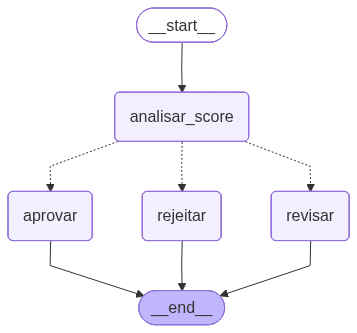


Leitura do grafo:
  __start__ → analisar_score → [decisão condicional] → aprovar/revisar/rejeitar → __end__

As linhas TRACEJADAS indicam arestas condicionais (função rotear_por_score decide)



In [52]:
# Visualizando o Grafo de Decisão

from IPython.display import Image, display

# Gera e exibe o diagrama
drawing = app_decisao.get_graph().draw_mermaid_png()
display(Image(drawing))

print("""
Leitura do grafo:
  __start__ → analisar_score → [decisão condicional] → aprovar/revisar/rejeitar → __end__
  
As linhas TRACEJADAS indicam arestas condicionais (função rotear_por_score decide)
""")

### 2.5 Testando as Arestas Condicionais

Agora vamos **provar que as arestas condicionais funcionam** passando diferentes valores de `score`. Observe:

- **Score 750** → Função `rotear_por_score` retorna `"aprovar"` → Nó `aprovar` é executado
- **Score 650** → Função `rotear_por_score` retorna `"revisar"` → Nó `revisar` é executado  
- **Score 400** → Função `rotear_por_score` retorna `"rejeitar"` → Nó `rejeitar` é executado

**O mesmo grafo, três caminhos diferentes!** A função de roteamento decide qual nó executa baseado no estado atual.

In [53]:
# Testando as 3 ramificações do grafo

cenarios = [
    {"nome": "João",  "score": 750, "esperado": "APROVADO"},   # score >= 700
    {"nome": "Maria", "score": 650, "esperado": "EM_REVISAO"}, # 500 <= score < 700
    {"nome": "Pedro", "score": 400, "esperado": "REJEITADO"},  # score < 500
]

for c in cenarios:
    estado = {"nome_cliente": c["nome"], "score": c["score"], "decisao": "", "motivo": "", "historico": []}
    resultado = app_decisao.invoke(estado)
    
    status = "✅" if resultado["decisao"] == c["esperado"] else "❌"
    print(f"{status} Score {c['score']:3d} → {resultado['decisao']:12s} (esperado: {c['esperado']})")

   📊 Analisando score de João: 750
   ✅ Crédito APROVADO para João
✅ Score 750 → APROVADO     (esperado: APROVADO)
   📊 Analisando score de Maria: 650
   ⚠️ Crédito enviado para REVISÃO - Maria
✅ Score 650 → EM_REVISAO   (esperado: EM_REVISAO)
   📊 Analisando score de Pedro: 400
   ❌ Crédito REJEITADO para Pedro
✅ Score 400 → REJEITADO    (esperado: REJEITADO)


### 2.6 Teste Simplificado do Motor de Decisão

Abaixo executamos o mesmo grafo com 3 clientes de uma vez. O código é mais compacto, mas o comportamento é idêntico ao teste anterior - cada cliente segue um caminho diferente no grafo baseado em seu score.

In [54]:
# Versão compacta: processando múltiplos clientes em loop

clientes = [
    {"nome_cliente": "Maria Silva", "score": 850},
    {"nome_cliente": "João Santos", "score": 620},
    {"nome_cliente": "Pedro Costa", "score": 380},
]

for cliente in clientes:
    estado = {**cliente, "decisao": "", "motivo": "", "historico": []}
    resultado = app_decisao.invoke(estado)
    print(f"{cliente['nome_cliente']:15s} | Score: {cliente['score']:3d} | → {resultado['decisao']}")

   📊 Analisando score de Maria Silva: 850
   ✅ Crédito APROVADO para Maria Silva
Maria Silva     | Score: 850 | → APROVADO
   📊 Analisando score de João Santos: 620
   ⚠️ Crédito enviado para REVISÃO - João Santos
João Santos     | Score: 620 | → EM_REVISAO
   📊 Analisando score de Pedro Costa: 380
   ❌ Crédito REJEITADO para Pedro Costa
Pedro Costa     | Score: 380 | → REJEITADO


---

## 📚 Parte 3: Estado Complexo e Gerenciamento Global

Agora vamos criar um estado mais completo para cenários reais do setor financeiro.

### 3.1 Modelando um Estado Complexo com TypedDict e Pydantic

Em sistemas reais, o estado de um grafo precisa armazenar muito mais informação. Aqui definimos:

1. **Enums** (`NivelRisco`, `StatusProcesso`) - Valores fixos que representam estados possíveis
2. **Classes Pydantic** (`DadosCliente`, `DadosOperacao`, `AnaliseRisco`) - Estruturas validadas para dados de entrada
3. **TypedDict** (`EstadoAnaliseCredito`) - O estado principal que flui pelo grafo

**Por que usar TypedDict com Annotated?**
```python
historico: Annotated[list[str], operator.add]  # ← O operador "add" ACUMULA valores
```
Isso significa que cada nó pode adicionar itens ao histórico sem sobrescrever os anteriores. O LangGraph sabe que deve concatenar as listas automaticamente.

In [55]:
# Definição de Estado Complexo para Análise de Crédito

from typing import TypedDict, Annotated, Optional, Literal
from pydantic import BaseModel, Field
from enum import Enum
from datetime import datetime
import operator

class NivelRisco(str, Enum):
    BAIXO = "BAIXO"
    MEDIO = "MÉDIO"
    ALTO = "ALTO"
    MUITO_ALTO = "MUITO_ALTO"

class StatusProcesso(str, Enum):
    INICIADO = "INICIADO"
    COLETANDO_DADOS = "COLETANDO_DADOS"
    CALCULANDO_RISCO = "CALCULANDO_RISCO"
    AGUARDANDO_APROVACAO = "AGUARDANDO_APROVAÇÃO_HUMANA"
    APROVADO = "APROVADO"
    REJEITADO = "REJEITADO"
    PENDENTE_DOCUMENTOS = "PENDENTE_DOCUMENTOS"

class DadosCliente(BaseModel):
    """Dados do cliente para análise."""
    nome: str
    cpf_cnpj: str
    tipo_pessoa: Literal["PF", "PJ"]
    renda_faturamento: float
    tempo_relacionamento_meses: int
    score_bureau: int
    restricoes: bool = False

class DadosOperacao(BaseModel):
    """Dados da operação de crédito."""
    valor_solicitado: float
    prazo_meses: int
    finalidade: str
    garantias_valor: float = 0.0

class AnaliseRisco(BaseModel):
    """Resultado da análise de risco."""
    score_interno: int = 0
    nivel_risco: Optional[NivelRisco] = None
    fatores_risco: list[str] = Field(default_factory=list)
    fatores_positivos: list[str] = Field(default_factory=list)
    taxa_juros_sugerida: Optional[float] = None
    limite_aprovado: Optional[float] = None

class AprovacaoHumana(BaseModel):
    """Registro de aprovação humana."""
    requerida: bool = False
    aprovador: Optional[str] = None
    data_aprovacao: Optional[str] = None
    decisao: Optional[Literal["APROVADO", "REJEITADO", "PENDENTE"]] = None
    comentarios: Optional[str] = None

# Estado principal do grafo
class EstadoAnaliseCredito(TypedDict):
    """Estado completo para análise de crédito."""
    # Identificação do processo
    processo_id: str
    status: StatusProcesso
    
    # Dados de entrada
    cliente: Optional[dict]  # DadosCliente serializado
    operacao: Optional[dict]  # DadosOperacao serializado
    
    # Análise
    analise: Optional[dict]  # AnaliseRisco serializado
    
    # Aprovação humana
    aprovacao_humana: Optional[dict]  # AprovacaoHumana serializado
    
    # Decisão final
    decisao_final: Optional[str]
    motivo_decisao: Optional[str]
    
    # Histórico de eventos (acumulativo)
    historico: Annotated[list[str], operator.add]
    
    # Controle de erro
    erro: Optional[str]

print("✅ Estado ComplexoAnaliseCredito definido!")
print(f"\n📋 Componentes do estado:")
print(f"   • DadosCliente: nome, cpf, tipo, renda, score, etc.")
print(f"   • DadosOperacao: valor, prazo, finalidade, garantias")
print(f"   • AnaliseRisco: score interno, nível, fatores, taxa sugerida")
print(f"   • AprovacaoHumana: aprovador, decisão, comentários")

✅ Estado ComplexoAnaliseCredito definido!

📋 Componentes do estado:
   • DadosCliente: nome, cpf, tipo, renda, score, etc.
   • DadosOperacao: valor, prazo, finalidade, garantias
   • AnaliseRisco: score interno, nível, fatores, taxa sugerida
   • AprovacaoHumana: aprovador, decisão, comentários


### 3.2 Funções Auxiliares: Log e Debug

Antes de criar os nós, definimos funções utilitárias para:
- `log_evento()` - Adiciona timestamp a cada ação (essencial para auditoria no setor financeiro)
- `imprimir_estado()` - Permite visualizar o estado atual durante debug

**Dica:** Em produção, esses logs seriam enviados para um sistema de observabilidade (DataDog, Grafana, etc.).

In [56]:
# Funções auxiliares para logging

def log_evento(mensagem: str) -> str:
    """Cria uma entrada de log com timestamp."""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"[{timestamp}] {mensagem}"

def imprimir_estado(state: EstadoAnaliseCredito, titulo: str = "Estado Atual"):
    """Imprime o estado de forma formatada."""
    print(f"\n📊 {titulo}")
    print("=" * 50)
    print(f"   Processo: {state.get('processo_id', 'N/A')}")
    print(f"   Status: {state.get('status', 'N/A')}")
    if state.get('cliente'):
        print(f"   Cliente: {state['cliente'].get('nome', 'N/A')}")
    if state.get('analise'):
        print(f"   Risco: {state['analise'].get('nivel_risco', 'N/A')}")
    if state.get('decisao_final'):
        print(f"   Decisão: {state['decisao_final']}")

print("✅ Funções auxiliares definidas!")

✅ Funções auxiliares definidas!


---

## 📚 Parte 4: Construindo o Motor de Decisão Completo

Agora vamos criar o fluxo completo de aprovação de crédito com todas as funcionalidades.

### 4.1 Os Nós do Motor de Decisão

Cada nó é uma **função Python pura** que:
1. Recebe o estado atual (`state: EstadoAnaliseCredito`)
2. Executa alguma lógica de negócio
3. Retorna um dicionário com os campos a serem atualizados

**Estrutura de um nó:**
```python
def nome_do_no(state: EstadoAnaliseCredito) -> dict:
    # 1. Lê dados do estado atual
    cliente = state["cliente"]
    
    # 2. Executa lógica
    resultado = processar(cliente)
    
    # 3. Retorna apenas os campos modificados
    return {
        "status": StatusProcesso.APROVADO,
        "historico": [log_evento("Ação executada")]
    }
```

O primeiro nó (`validar_entrada`) verifica se os dados obrigatórios existem antes de prosseguir.

In [57]:
# Nós do Motor de Decisão

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import json

# LLM para análises
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# ============ NÓ 1: Validar Dados de Entrada ============
def validar_entrada(state: EstadoAnaliseCredito) -> dict:
    """Valida se todos os dados necessários estão presentes."""
    print("\n🔍 [Nó: validar_entrada]")
    
    erros = []
    
    # Valida cliente
    if not state.get("cliente"):
        erros.append("Dados do cliente não fornecidos")
    else:
        cliente = state["cliente"]
        if not cliente.get("nome"):
            erros.append("Nome do cliente é obrigatório")
        if not cliente.get("cpf_cnpj"):
            erros.append("CPF/CNPJ é obrigatório")
        if not cliente.get("renda_faturamento") or cliente["renda_faturamento"] <= 0:
            erros.append("Renda/Faturamento inválido")
    
    # Valida operação
    if not state.get("operacao"):
        erros.append("Dados da operação não fornecidos")
    else:
        operacao = state["operacao"]
        if not operacao.get("valor_solicitado") or operacao["valor_solicitado"] <= 0:
            erros.append("Valor solicitado inválido")
    
    if erros:
        return {
            "status": StatusProcesso.REJEITADO,
            "erro": "; ".join(erros),
            "decisao_final": "REJEITADO",
            "motivo_decisao": f"Dados inválidos: {'; '.join(erros)}",
            "historico": [log_evento(f"❌ Validação falhou: {'; '.join(erros)}")]
        }
    
    print(f"   ✅ Dados validados para {state['cliente']['nome']}")
    return {
        "status": StatusProcesso.COLETANDO_DADOS,
        "historico": [log_evento(f"✅ Dados validados com sucesso")]
    }

In [58]:
# ============ NÓ 2: Calcular Score de Risco ============

def calcular_risco(state: EstadoAnaliseCredito) -> dict:  # Changed from EstadoAnaliseCredito
    """Calcula o score de risco interno baseado em múltiplos fatores."""
    print("\n📊 [Nó: calcular_risco]")
    
    
    cliente = state["cliente"]
    operacao = state["operacao"]
    
    # Inicializa análise
    score = 0
    fatores_risco = []
    fatores_positivos = []
    
    # ===== FATOR 1: Score do Bureau (peso: 30%) =====
    score_bureau = cliente.get("score_bureau", 0)
    if score_bureau >= 800:
        score += 30
        fatores_positivos.append(f"Score bureau excelente ({score_bureau})")
    elif score_bureau >= 700:
        score += 25
        fatores_positivos.append(f"Score bureau bom ({score_bureau})")
    elif score_bureau >= 600:
        score += 15
        fatores_risco.append(f"Score bureau médio ({score_bureau})")
    elif score_bureau >= 500:
        score += 5
        fatores_risco.append(f"Score bureau baixo ({score_bureau})")
    else:
        fatores_risco.append(f"Score bureau muito baixo ({score_bureau})")
    
    # ===== FATOR 2: Tempo de Relacionamento (peso: 15%) =====
    tempo_rel = cliente.get("tempo_relacionamento_meses", 0)
    if tempo_rel >= 60:  # 5+ anos
        score += 15
        fatores_positivos.append(f"Cliente antigo ({tempo_rel} meses)")
    elif tempo_rel >= 24:  # 2+ anos
        score += 10
        fatores_positivos.append(f"Bom tempo de relacionamento ({tempo_rel} meses)")
    elif tempo_rel >= 6:
        score += 5
    else:
        fatores_risco.append(f"Cliente novo ({tempo_rel} meses)")
    
    # ===== FATOR 3: Comprometimento de Renda (peso: 25%) =====
    renda = cliente.get("renda_faturamento", 1)
    valor_solicitado = operacao.get("valor_solicitado", 0)
    prazo = operacao.get("prazo_meses", 1)
    parcela_estimada = valor_solicitado / prazo
    comprometimento = (parcela_estimada / renda) * 100 if renda > 0 else 100
    
    if comprometimento <= 20:
        score += 25
        fatores_positivos.append(f"Baixo comprometimento de renda ({comprometimento:.1f}%)")
    elif comprometimento <= 30:
        score += 20
        fatores_positivos.append(f"Comprometimento adequado ({comprometimento:.1f}%)")
    elif comprometimento <= 40:
        score += 10
        fatores_risco.append(f"Comprometimento elevado ({comprometimento:.1f}%)")
    elif comprometimento <= 50:
        score += 5
        fatores_risco.append(f"Comprometimento alto ({comprometimento:.1f}%)")
    else:
        fatores_risco.append(f"Comprometimento excessivo ({comprometimento:.1f}%)")
    
    # ===== FATOR 4: Garantias (peso: 20%) =====
    garantias = operacao.get("garantias_valor", 0)
    cobertura = (garantias / valor_solicitado) * 100 if valor_solicitado > 0 else 0
    
    if cobertura >= 150:
        score += 20
        fatores_positivos.append(f"Garantias robustas ({cobertura:.1f}%)")
    elif cobertura >= 100:
        score += 15
        fatores_positivos.append(f"Garantias adequadas ({cobertura:.1f}%)")
    elif cobertura >= 50:
        score += 10
        fatores_risco.append(f"Garantias parciais ({cobertura:.1f}%)")
    elif cobertura > 0:
        score += 5
        fatores_risco.append(f"Garantias insuficientes ({cobertura:.1f}%)")
    else:
        fatores_risco.append("Sem garantias")
    
    # ===== FATOR 5: Restrições (peso: 10%) =====
    if not cliente.get("restricoes", False):
        score += 10
        fatores_positivos.append("Sem restrições cadastrais")
    else:
        fatores_risco.append("Possui restrições cadastrais")
    
    # ===== Determina Nível de Risco =====
    if score >= 80:
        nivel_risco = NivelRisco.BAIXO
        taxa_sugerida = 1.5
        limite_aprovado = valor_solicitado
    elif score >= 60:
        nivel_risco = NivelRisco.MEDIO
        taxa_sugerida = 2.2
        limite_aprovado = valor_solicitado * 0.8  # 80% do solicitado
    elif score >= 40:
        nivel_risco = NivelRisco.ALTO
        taxa_sugerida = 3.0
        limite_aprovado = valor_solicitado * 0.5  # 50% do solicitado
    else:
        nivel_risco = NivelRisco.MUITO_ALTO
        taxa_sugerida = None
        limite_aprovado = 0
    
    analise = {
        "score_interno": score,
        "nivel_risco": nivel_risco.value,
        "fatores_risco": fatores_risco,
        "fatores_positivos": fatores_positivos,
        "taxa_juros_sugerida": taxa_sugerida,
        "limite_aprovado": limite_aprovado
    }
    
    print(f"   📈 Score calculado: {score}/100")
    print(f"   🎯 Nível de risco: {nivel_risco.value}")
    
    return {
        "status": StatusProcesso.CALCULANDO_RISCO,
        "analise": analise,
        "historico": [log_evento(f"📊 Risco calculado: {nivel_risco.value} (score: {score})")]
    }

print("✅ Nó 'calcular_risco' definido!")

✅ Nó 'calcular_risco' definido!


In [59]:
# ============ NÓ 3: Aprovar Automático ============

def aprovar_automatico(state: EstadoAnaliseCredito) -> dict:  # Changed return type
    """Aprova automaticamente operações de baixo risco."""
    print("\n✅ [Nó: aprovar_automatico]")
    
    analise = state["analise"]
    cliente = state["cliente"]
    
    # Guard against None values
    if analise is None or cliente is None:
        return {
            "status": StatusProcesso.REJEITADO,
            "decisao_final": "REJEITADO",
            "motivo_decisao": "Erro interno: dados de análise não disponíveis",
            "historico": [log_evento("❌ Erro: análise ou cliente não encontrados")]
        }
    
    print(f"   🎉 Crédito aprovado automaticamente para {cliente['nome']}")
    print(f"   💰 Valor aprovado: R$ {analise['limite_aprovado']:,.2f}")
    print(f"   📊 Taxa: {analise['taxa_juros_sugerida']}% a.m.")
    
    return {
        "status": StatusProcesso.APROVADO,
        "decisao_final": "APROVADO",
        "motivo_decisao": f"Aprovação automática - Risco {analise['nivel_risco']} (Score: {analise['score_interno']})",
        "historico": [log_evento(f"✅ APROVADO AUTOMATICAMENTE - Valor: R$ {analise['limite_aprovado']:,.2f}")]
    }
print("✅ Nó 'aprovar_automatico' definido!")

✅ Nó 'aprovar_automatico' definido!


In [60]:
# ============ NÓ 4: Solicitar Aprovação Humana (Human-in-the-Loop) ============

def solicitar_aprovacao_humana(state: EstadoAnaliseCredito) -> dict:
    """Prepara o processo para aprovação humana."""
    print("\n⏸️ [Nó: solicitar_aprovacao_humana]")
    
    analise = state["analise"]
    cliente = state["cliente"]
    
    # Guard against None values
    if analise is None or cliente is None:
        return {
            "status": StatusProcesso.REJEITADO,
            "decisao_final": "REJEITADO",
            "motivo_decisao": "Erro interno: dados não disponíveis",
            "historico": [log_evento("❌ Erro: análise ou cliente não encontrados")]
        }
    
    print(f"   ⚠️ Operação requer aprovação humana")
    print(f"   👤 Cliente: {cliente['nome']}")
    print(f"   🎯 Risco: {analise['nivel_risco']}")
    print(f"   \n   📋 Fatores de Risco:")
    for fator in analise.get('fatores_risco', []):
        print(f"      ⚠️ {fator}")
    print(f"   \n   ✅ Fatores Positivos:")
    for fator in analise.get('fatores_positivos', []):
        print(f"      ✅ {fator}")
    
    aprovacao = {
        "requerida": True,
        "aprovador": None,
        "data_aprovacao": None,
        "decisao": "PENDENTE",
        "comentarios": None
    }
    
    return {
        "status": StatusProcesso.AGUARDANDO_APROVACAO,
        "aprovacao_humana": aprovacao,
        "historico": [log_evento(f"⏸️ Aguardando aprovação humana - Risco: {analise['nivel_risco']}")]
    }

print("✅ Nó 'solicitar_aprovacao_humana' definido!")

✅ Nó 'solicitar_aprovacao_humana' definido!


In [61]:
# ============ NÓ 5: Processar Decisão Humana ============

def processar_decisao_humana(state: EstadoAnaliseCredito) -> dict:
    """Processa a decisão do aprovador humano."""
    print("\n👨‍💼 [Nó: processar_decisao_humana]")
    
    aprovacao = state.get("aprovacao_humana") or {}
    
    decisao = aprovacao.get("decisao", "PENDENTE")
    aprovador = aprovacao.get("aprovador", "Sistema")
    comentarios = aprovacao.get("comentarios", "")
    
    if decisao == "APROVADO":
        print(f"   ✅ Aprovado por {aprovador}")
        return {
            "status": StatusProcesso.APROVADO,
            "decisao_final": "APROVADO",
            "motivo_decisao": f"Aprovado por {aprovador}. {comentarios}",
            "historico": [log_evento(f"✅ APROVADO por {aprovador}: {comentarios}")]
        }
    elif decisao == "REJEITADO":
        print(f"   ❌ Rejeitado por {aprovador}")
        return {
            "status": StatusProcesso.REJEITADO,
            "decisao_final": "REJEITADO",
            "motivo_decisao": f"Rejeitado por {aprovador}. {comentarios}",
            "historico": [log_evento(f"❌ REJEITADO por {aprovador}: {comentarios}")]
        }
    else:
        print(f"   ⏳ Ainda aguardando decisão...")
        return {
            "historico": [log_evento("⏳ Aguardando decisão humana")]
        }

print("✅ Nó 'processar_decisao_humana' definido!")

✅ Nó 'processar_decisao_humana' definido!


In [62]:
# ============ NÓ 6: Rejeitar Automático ============

def rejeitar_automatico(state: EstadoAnaliseCredito) -> dict:
    """Rejeita automaticamente operações de risco muito alto."""
    print("\n❌ [Nó: rejeitar_automatico]")
    
    analise = state["analise"]
    cliente = state["cliente"]
    
    # Guard against None values
    if analise is None or cliente is None:
        return {
            "status": StatusProcesso.REJEITADO,
            "decisao_final": "REJEITADO",
            "motivo_decisao": "Rejeição por dados insuficientes",
            "historico": [log_evento("❌ REJEITADO - Dados insuficientes")]
        }
    
    print(f"   ❌ Crédito rejeitado automaticamente para {cliente['nome']}")
    print(f"   📊 Score: {analise['score_interno']}/100")
    print(f"   ⚠️ Fatores de rejeição:")
    for fator in analise.get('fatores_risco', []):
        print(f"      • {fator}")
    
    return {
        "status": StatusProcesso.REJEITADO,
        "decisao_final": "REJEITADO",
        "motivo_decisao": f"Rejeição automática - Risco {analise['nivel_risco']} (Score: {analise['score_interno']})",
        "historico": [log_evento(f"❌ REJEITADO AUTOMATICAMENTE - Score: {analise['score_interno']}")]
    }

print("✅ Nó 'rejeitar_automatico' definido!")

✅ Nó 'rejeitar_automatico' definido!


In [63]:
# ============ NÓ 7: Gerar Contrato ============

def gerar_contrato(state: EstadoAnaliseCredito) -> dict:
    """Gera o contrato para operações aprovadas."""
    print("\n📄 [Nó: gerar_contrato]")
    
    cliente = state["cliente"]
    operacao = state["operacao"]
    analise = state["analise"]
    
    # Guard against None values
    if cliente is None or operacao is None or analise is None:
        return {
            "historico": [log_evento("⚠️ Contrato gerado com dados parciais")]
        }
    
    print(f"   📝 Gerando contrato para {cliente['nome']}")
    print(f"   💰 Valor: R$ {analise['limite_aprovado']:,.2f}")
    print(f"   📊 Taxa: {analise['taxa_juros_sugerida']}% a.m.")
    print(f"   📅 Prazo: {operacao['prazo_meses']} meses")
    
    # Em produção, aqui seria gerado o PDF do contrato
    contrato_id = f"CTR-{state['processo_id']}-{datetime.now().strftime('%Y%m%d')}"

    print("✅ Nó 'gerar_contrato' definido!")

    return {

        "historico": [log_evento(f"📄 Contrato gerado: {contrato_id}")]    }

In [64]:
# ============ Função de Roteamento ============

def rotear_por_risco(state: EstadoAnaliseCredito) -> Literal["aprovar_automatico", "solicitar_aprovacao_humana", "rejeitar_automatico"]:
    """Roteia o fluxo baseado no nível de risco calculado."""
    
    # Se houve erro na validação
    if state.get("erro"):
        return "rejeitar_automatico"
    
    analise = state.get("analise", {})
    nivel_risco = analise.get("nivel_risco", "MUITO_ALTO")
    
    print(f"\n🔀 [Roteamento] Nível de risco: {nivel_risco}")
    
    if nivel_risco == "BAIXO":
        print("   → Rota: aprovar_automatico")
        return "aprovar_automatico"
    elif nivel_risco in ["MÉDIO", "ALTO"]:
        print("   → Rota: solicitar_aprovacao_humana")
        return "solicitar_aprovacao_humana"
    else:  # MUITO_ALTO
        print("   → Rota: rejeitar_automatico")
        return "rejeitar_automatico"

def verificar_validacao(state: EstadoAnaliseCredito) -> Literal["calcular_risco", "fim"]:
    """Verifica se a validação passou."""
    if state.get("erro") or state.get("status") == StatusProcesso.REJEITADO:
        return "fim"
    return "calcular_risco"

print("✅ Funções de roteamento definidas!")

✅ Funções de roteamento definidas!


In [65]:
# ============ Montando o Grafo Completo ============

from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# Cria o grafo
workflow = StateGraph(EstadoAnaliseCredito)

# Adiciona todos os nós
workflow.add_node("validar_entrada", validar_entrada)
workflow.add_node("calcular_risco", calcular_risco)
workflow.add_node("aprovar_automatico", aprovar_automatico)
workflow.add_node("solicitar_aprovacao_humana", solicitar_aprovacao_humana)
workflow.add_node("processar_decisao_humana", processar_decisao_humana)
workflow.add_node("rejeitar_automatico", rejeitar_automatico)
workflow.add_node("gerar_contrato", gerar_contrato)

# Define o fluxo
workflow.add_edge(START, "validar_entrada")

# Após validação: continua ou termina
workflow.add_conditional_edges(
    "validar_entrada",
    verificar_validacao,
    {
        "calcular_risco": "calcular_risco",
        "fim": END
    }
)

# Após cálculo de risco: roteia por nível
workflow.add_conditional_edges(
    "calcular_risco",
    rotear_por_risco,
    {
        "aprovar_automatico": "aprovar_automatico",
        "solicitar_aprovacao_humana": "solicitar_aprovacao_humana",
        "rejeitar_automatico": "rejeitar_automatico"
    }
)

# Após aprovação automática: gera contrato
workflow.add_edge("aprovar_automatico", "gerar_contrato")
workflow.add_edge("gerar_contrato", END)

# Após rejeição automática: termina
workflow.add_edge("rejeitar_automatico", END)

# Human-in-the-loop: pausa para aprovação
# O fluxo será retomado manualmente após aprovação humana
workflow.add_edge("solicitar_aprovacao_humana", "processar_decisao_humana")

# Após decisão humana: roteia novamente
def rotear_apos_decisao_humana(state: EstadoAnaliseCredito) -> Literal["gerar_contrato", "fim"]:
    decisao = state.get("decisao_final")
    if decisao == "APROVADO":
        return "gerar_contrato"
    return "fim"

workflow.add_conditional_edges(
    "processar_decisao_humana",
    rotear_apos_decisao_humana,
    {
        "gerar_contrato": "gerar_contrato",
        "fim": END
    }
)

# Compila com checkpoint para persistência
checkpointer = MemorySaver()
motor_decisao = workflow.compile(checkpointer=checkpointer)

print("✅ MOTOR DE DECISÃO COMPILADO!")
print("\n📊 Estrutura do Grafo:")
print("   START → validar_entrada → calcular_risco")
print("   ↳ [BAIXO] → aprovar_automatico → gerar_contrato → END")
print("   ↳ [MÉDIO/ALTO] → solicitar_aprovacao → processar_decisao → ...")
print("   ↳ [MUITO_ALTO] → rejeitar_automatico → END")

✅ MOTOR DE DECISÃO COMPILADO!

📊 Estrutura do Grafo:
   START → validar_entrada → calcular_risco
   ↳ [BAIXO] → aprovar_automatico → gerar_contrato → END
   ↳ [MÉDIO/ALTO] → solicitar_aprovacao → processar_decisao → ...
   ↳ [MUITO_ALTO] → rejeitar_automatico → END


### 4.7 Visualizando o Motor de Decisão Completo

O grafo abaixo mostra toda a complexidade do fluxo de aprovação de crédito. Note:
- **Linhas sólidas** = arestas fixas (sempre seguem esse caminho)
- **Linhas tracejadas** = arestas condicionais (dependem do resultado de uma função)

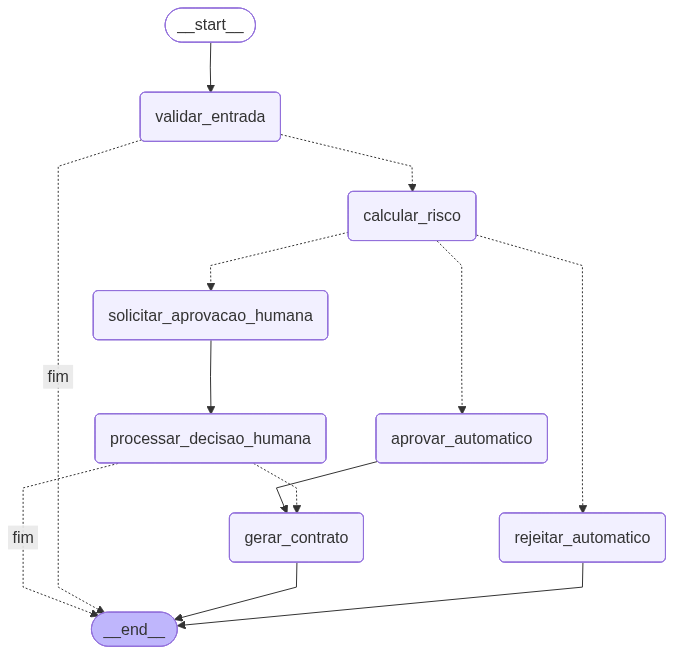


📖 LEITURA DO GRAFO:

1. __start__ → validar_entrada
   Todo processo começa pela validação dos dados

2. validar_entrada → calcular_risco OU → __end__
   Se dados inválidos, encerra. Se válidos, calcula risco.

3. calcular_risco → 3 caminhos possíveis:
   ├─ aprovar_automatico (risco BAIXO)
   ├─ solicitar_aprovacao_humana (risco MÉDIO/ALTO)
   └─ rejeitar_automatico (risco MUITO_ALTO)

4. solicitar_aprovacao_humana → processar_decisao_humana
   Aqui o processo PAUSA aguardando intervenção humana

5. processar_decisao_humana → gerar_contrato OU → __end__
   Humano aprovou? Gera contrato. Rejeitou? Encerra.

6. gerar_contrato → __end__
   Processo finalizado com sucesso!



In [66]:
# Visualizando o Motor de Decisão Completo

from IPython.display import Image, display

drawing_motor = motor_decisao.get_graph().draw_mermaid_png()
display(Image(drawing_motor))

print("""
📖 LEITURA DO GRAFO:

1. __start__ → validar_entrada
   Todo processo começa pela validação dos dados

2. validar_entrada → calcular_risco OU → __end__
   Se dados inválidos, encerra. Se válidos, calcula risco.

3. calcular_risco → 3 caminhos possíveis:
   ├─ aprovar_automatico (risco BAIXO)
   ├─ solicitar_aprovacao_humana (risco MÉDIO/ALTO)
   └─ rejeitar_automatico (risco MUITO_ALTO)

4. solicitar_aprovacao_humana → processar_decisao_humana
   Aqui o processo PAUSA aguardando intervenção humana

5. processar_decisao_humana → gerar_contrato OU → __end__
   Humano aprovou? Gera contrato. Rejeitou? Encerra.

6. gerar_contrato → __end__
   Processo finalizado com sucesso!
""")


---

## 🏗️ Parte 5: Testando o Motor de Decisão

Vamos testar o motor com diferentes cenários!

In [67]:
# Função auxiliar para criar estado inicial

import uuid

def criar_solicitacao(
    nome: str,
    cpf_cnpj: str,
    tipo_pessoa: str,
    renda: float,
    tempo_relacionamento: int,
    score_bureau: int,
    restricoes: bool,
    valor_solicitado: float,
    prazo_meses: int,
    finalidade: str,
    garantias: float = 0.0
) -> EstadoAnaliseCredito:
    """Cria uma solicitação de crédito para processamento."""
    
    return {
        "processo_id": str(uuid.uuid4())[:8].upper(),
        "status": StatusProcesso.INICIADO,
        "cliente": {
            "nome": nome,
            "cpf_cnpj": cpf_cnpj,
            "tipo_pessoa": tipo_pessoa,
            "renda_faturamento": renda,
            "tempo_relacionamento_meses": tempo_relacionamento,
            "score_bureau": score_bureau,
            "restricoes": restricoes
        },
        "operacao": {
            "valor_solicitado": valor_solicitado,
            "prazo_meses": prazo_meses,
            "finalidade": finalidade,
            "garantias_valor": garantias
        },
        "analise": None,
        "aprovacao_humana": None,
        "decisao_final": None,
        "motivo_decisao": None,
        "historico": [log_evento("🚀 Solicitação iniciada")],
        "erro": None
    }

print("✅ Função criar_solicitacao definida!")

✅ Função criar_solicitacao definida!


In [69]:
# CENÁRIO 1: Cliente de Baixo Risco (Aprovação Automática)

print("\n" + "="*70)
print("🧪 CENÁRIO 1: Cliente de Baixo Risco")
print("="*70)

solicitacao_baixo_risco = criar_solicitacao(
    nome="Ana Carolina Mendes",
    cpf_cnpj="123.456.789-00",
    tipo_pessoa="PF",
    renda=25000.00,
    tempo_relacionamento=72,  # 6 anos
    score_bureau=850,
    restricoes=False,
    valor_solicitado=50000.00,
    prazo_meses=24,
    finalidade="Reforma residencial",
    garantias=80000.00  # 160% de cobertura
)

# Executa o motor
config = {"configurable": {"thread_id": solicitacao_baixo_risco["processo_id"]}}
resultado1 = motor_decisao.invoke(solicitacao_baixo_risco, config)

print("\n" + "="*70)
print("📋 RESULTADO FINAL:")
print(f"   Status: {resultado1['status']}")
print(f"   Decisão: {resultado1['decisao_final']}")
print(f"   Motivo: {resultado1['motivo_decisao']}")
print("\n📜 Histórico:")
for evento in resultado1['historico']:
    print(f"   {evento}")


🧪 CENÁRIO 1: Cliente de Baixo Risco

🔍 [Nó: validar_entrada]
   ✅ Dados validados para Ana Carolina Mendes

📊 [Nó: calcular_risco]
   📈 Score calculado: 100/100
   🎯 Nível de risco: BAIXO

🔀 [Roteamento] Nível de risco: BAIXO
   → Rota: aprovar_automatico

✅ [Nó: aprovar_automatico]
   🎉 Crédito aprovado automaticamente para Ana Carolina Mendes
   💰 Valor aprovado: R$ 50,000.00
   📊 Taxa: 1.5% a.m.

📄 [Nó: gerar_contrato]
   📝 Gerando contrato para Ana Carolina Mendes
   💰 Valor: R$ 50,000.00
   📊 Taxa: 1.5% a.m.
   📅 Prazo: 24 meses
✅ Nó 'gerar_contrato' definido!

📋 RESULTADO FINAL:
   Status: StatusProcesso.APROVADO
   Decisão: APROVADO
   Motivo: Aprovação automática - Risco BAIXO (Score: 100)

📜 Histórico:
   [2026-01-30 11:04:38] 🚀 Solicitação iniciada
   [2026-01-30 11:04:38] ✅ Dados validados com sucesso
   [2026-01-30 11:04:38] 📊 Risco calculado: BAIXO (score: 100)
   [2026-01-30 11:04:38] ✅ APROVADO AUTOMATICAMENTE - Valor: R$ 50,000.00
   [2026-01-30 11:04:38] 📄 Contrato ge

In [70]:
# CENÁRIO 2: Cliente de Risco Muito Alto (Rejeição Automática)

print("\n" + "="*70)
print("🧪 CENÁRIO 2: Cliente de Risco Muito Alto")
print("="*70)

solicitacao_alto_risco = criar_solicitacao(
    nome="Pedro Henrique Silva",
    cpf_cnpj="987.654.321-00",
    tipo_pessoa="PF",
    renda=3500.00,
    tempo_relacionamento=3,  # 3 meses
    score_bureau=380,
    restricoes=True,
    valor_solicitado=100000.00,
    prazo_meses=48,
    finalidade="Capital de giro",
    garantias=0.0  # Sem garantias
)

config2 = {"configurable": {"thread_id": solicitacao_alto_risco["processo_id"]}}
resultado2 = motor_decisao.invoke(solicitacao_alto_risco, config2)

print("\n" + "="*70)
print("📋 RESULTADO FINAL:")
print(f"   Status: {resultado2['status']}")
print(f"   Decisão: {resultado2['decisao_final']}")
print(f"   Motivo: {resultado2['motivo_decisao']}")
print("\n📜 Histórico:")
for evento in resultado2['historico']:
    print(f"   {evento}")


🧪 CENÁRIO 2: Cliente de Risco Muito Alto

🔍 [Nó: validar_entrada]
   ✅ Dados validados para Pedro Henrique Silva

📊 [Nó: calcular_risco]
   📈 Score calculado: 0/100
   🎯 Nível de risco: MUITO_ALTO

🔀 [Roteamento] Nível de risco: MUITO_ALTO
   → Rota: rejeitar_automatico

❌ [Nó: rejeitar_automatico]
   ❌ Crédito rejeitado automaticamente para Pedro Henrique Silva
   📊 Score: 0/100
   ⚠️ Fatores de rejeição:
      • Score bureau muito baixo (380)
      • Cliente novo (3 meses)
      • Comprometimento excessivo (59.5%)
      • Sem garantias
      • Possui restrições cadastrais

📋 RESULTADO FINAL:
   Status: StatusProcesso.REJEITADO
   Decisão: REJEITADO
   Motivo: Rejeição automática - Risco MUITO_ALTO (Score: 0)

📜 Histórico:
   [2026-01-30 11:10:13] 🚀 Solicitação iniciada
   [2026-01-30 11:10:13] ✅ Dados validados com sucesso
   [2026-01-30 11:10:13] 📊 Risco calculado: MUITO_ALTO (score: 0)
   [2026-01-30 11:10:13] ❌ REJEITADO AUTOMATICAMENTE - Score: 0


Deletar - celula

In [71]:
# CENÁRIO 3: Cliente de Risco Médio (Requer Aprovação Humana)

print("\n" + "="*70)
print("🧪 CENÁRIO 3: Cliente de Risco Médio - HUMAN-IN-THE-LOOP")
print("="*70)

solicitacao_medio_risco = criar_solicitacao(
    nome="Fernanda Costa Santos",
    cpf_cnpj="456.789.123-00",
    tipo_pessoa="PF",
    renda=12000.00,
    tempo_relacionamento=18,  # 1.5 anos
    score_bureau=680,
    restricoes=False,
    valor_solicitado=80000.00,
    prazo_meses=36,
    finalidade="Compra de veículo",
    garantias=50000.00  # ~63% de cobertura
)

config3 = {"configurable": {"thread_id": solicitacao_medio_risco["processo_id"]}}
resultado3 = motor_decisao.invoke(solicitacao_medio_risco, config3)

print("\n" + "="*70)
print("📋 STATUS ATUAL:")
print(f"   Status: {resultado3['status']}")
print(f"   Aguardando: Aprovação Humana")
print("\n📜 Histórico:")
for evento in resultado3['historico']:
    print(f"   {evento}")


🧪 CENÁRIO 3: Cliente de Risco Médio - HUMAN-IN-THE-LOOP

🔍 [Nó: validar_entrada]
   ✅ Dados validados para Fernanda Costa Santos

📊 [Nó: calcular_risco]
   📈 Score calculado: 65/100
   🎯 Nível de risco: MÉDIO

🔀 [Roteamento] Nível de risco: MÉDIO
   → Rota: solicitar_aprovacao_humana

⏸️ [Nó: solicitar_aprovacao_humana]
   ⚠️ Operação requer aprovação humana
   👤 Cliente: Fernanda Costa Santos
   🎯 Risco: MÉDIO
   
   📋 Fatores de Risco:
      ⚠️ Score bureau médio (680)
      ⚠️ Garantias parciais (62.5%)
   
   ✅ Fatores Positivos:
      ✅ Baixo comprometimento de renda (18.5%)
      ✅ Sem restrições cadastrais

👨‍💼 [Nó: processar_decisao_humana]
   ⏳ Ainda aguardando decisão...

📋 STATUS ATUAL:
   Status: StatusProcesso.AGUARDANDO_APROVACAO
   Aguardando: Aprovação Humana

📜 Histórico:
   [2026-01-30 11:12:07] 🚀 Solicitação iniciada
   [2026-01-30 11:12:07] ✅ Dados validados com sucesso
   [2026-01-30 11:12:07] 📊 Risco calculado: MÉDIO (score: 65)
   [2026-01-30 11:12:07] ⏸️ Aguard

---

## 📚 Parte 6: Implementando Human-in-the-Loop com Breakpoints

Agora vamos ver como **pausar** o fluxo e **retomar** após uma decisão humana real.

Esta é uma das funcionalidades mais poderosas do LangGraph!

In [38]:
# Recriando o grafo com interrupt_before para Human-in-the-Loop real

from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# Novo grafo com breakpoint
workflow_hitl = StateGraph(EstadoAnaliseCredito)

# Adiciona todos os nós
workflow_hitl.add_node("validar_entrada", validar_entrada)
workflow_hitl.add_node("calcular_risco", calcular_risco)
workflow_hitl.add_node("aprovar_automatico", aprovar_automatico)
workflow_hitl.add_node("solicitar_aprovacao_humana", solicitar_aprovacao_humana)
workflow_hitl.add_node("processar_decisao_humana", processar_decisao_humana)
workflow_hitl.add_node("rejeitar_automatico", rejeitar_automatico)
workflow_hitl.add_node("gerar_contrato", gerar_contrato)

# Mesmo fluxo de antes
workflow_hitl.add_edge(START, "validar_entrada")
workflow_hitl.add_conditional_edges("validar_entrada", verificar_validacao, {"calcular_risco": "calcular_risco", "fim": END})
workflow_hitl.add_conditional_edges("calcular_risco", rotear_por_risco, {
    "aprovar_automatico": "aprovar_automatico",
    "solicitar_aprovacao_humana": "solicitar_aprovacao_humana",
    "rejeitar_automatico": "rejeitar_automatico"
})
workflow_hitl.add_edge("aprovar_automatico", "gerar_contrato")
workflow_hitl.add_edge("gerar_contrato", END)
workflow_hitl.add_edge("rejeitar_automatico", END)
workflow_hitl.add_edge("solicitar_aprovacao_humana", "processar_decisao_humana")
workflow_hitl.add_conditional_edges("processar_decisao_humana", rotear_apos_decisao_humana, {
    "gerar_contrato": "gerar_contrato",
    "fim": END
})

# Compila COM BREAKPOINT antes de processar decisão humana
checkpointer_hitl = MemorySaver()
motor_hitl = workflow_hitl.compile(
    checkpointer=checkpointer_hitl,
    interrupt_before=["processar_decisao_humana"]  # PAUSA AQUI!
)

print("✅ Motor com Human-in-the-Loop compilado!")
print("   🛑 Breakpoint configurado antes de 'processar_decisao_humana'")

✅ Motor com Human-in-the-Loop compilado!
   🛑 Breakpoint configurado antes de 'processar_decisao_humana'


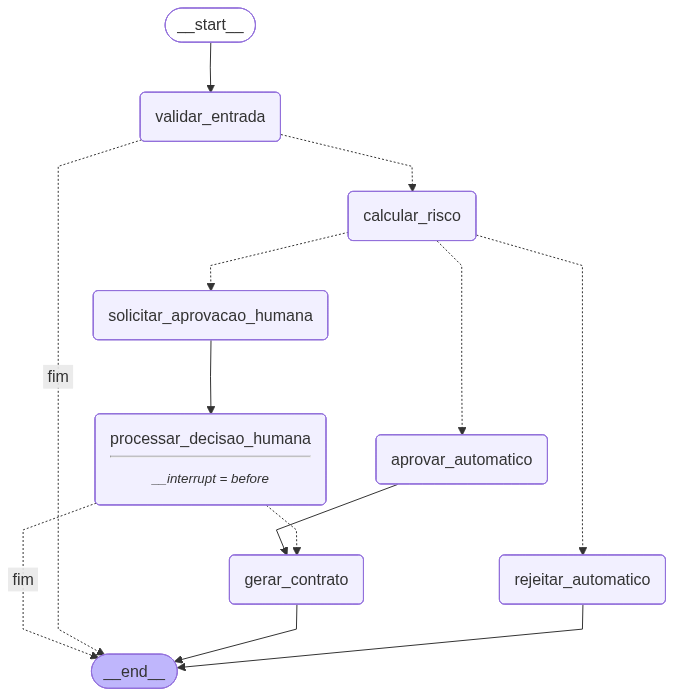


Este grafo é IDÊNTICO ao anterior, mas com uma diferença crucial:
→ O parâmetro interrupt_before=["processar_decisao_humana"] faz o fluxo PAUSAR
→ O sistema aguarda intervenção externa antes de continuar
→ Isso permite integração com sistemas de workflow humano



In [72]:
# Visualizando o Grafo com Human-in-the-Loop

from IPython.display import Image, display

drawing_hitl = motor_hitl.get_graph().draw_mermaid_png()
display(Image(drawing_hitl))

print("""
Este grafo é IDÊNTICO ao anterior, mas com uma diferença crucial:
→ O parâmetro interrupt_before=["processar_decisao_humana"] faz o fluxo PAUSAR
→ O sistema aguarda intervenção externa antes de continuar
→ Isso permite integração com sistemas de workflow humano
""")

In [73]:
# Simulando o fluxo completo com pausa para aprovação humana

print("\n" + "="*70)
print("🧪 DEMONSTRAÇÃO: Human-in-the-Loop com Breakpoint")
print("="*70)

# Cria solicitação de risco MÉDIO (não baixo!)
# Para ativar o Human-in-the-Loop, o cliente precisa ter risco MÉDIO ou ALTO
# Score bureau menor + menos tempo de relacionamento = risco maior
solicitacao_hitl = criar_solicitacao(
    nome="Roberto Almeida Junior",
    cpf_cnpj="789.123.456-00",
    tipo_pessoa="PF",
    renda=8000.00,              # Renda menor
    tempo_relacionamento=12,    # Menos tempo (1 ano)
    score_bureau=620,           # Score mais baixo (ainda aceitável)
    restricoes=False,
    valor_solicitado=80000.00,  # Valor alto em relação à renda
    prazo_meses=48,
    finalidade="Reforma e ampliação",
    garantias=30000.00          # Garantias menores
)

thread_id = solicitacao_hitl["processo_id"]
config_hitl = {"configurable": {"thread_id": thread_id}}

print(f"\n🆔 ID do Processo: {thread_id}")
print("\n" + "-"*70)
print("FASE 1: Processamento até o breakpoint")
print("-"*70)

# Executa até o breakpoint
resultado_parcial = motor_hitl.invoke(solicitacao_hitl, config_hitl)

print("\n" + "="*70)
if resultado_parcial.get('status') == StatusProcesso.AGUARDANDO_APROVACAO:
    print("⏸️ PROCESSO PAUSADO - Aguardando SUA aprovação humana!")
else:
    print(f"⚠️ ATENÇÃO: Processo NÃO pausou! Status: {resultado_parcial.get('status')}")
    print("   (Se o risco for BAIXO, vai direto para aprovação automática)")
    print("   (Se o risco for MUITO_ALTO, vai direto para rejeição automática)")
print("="*70)

print(f"\nStatus: {resultado_parcial['status']}")
print(f"\n📊 Análise de Risco:")
if resultado_parcial.get('analise'):
    analise = resultado_parcial['analise']
    print(f"   Score: {analise['score_interno']}/100")
    print(f"   Nível: {analise['nivel_risco']}")
    print(f"   Valor sugerido: R$ {analise.get('limite_aprovado', 0):,.2f}")
    print(f"   Taxa sugerida: {analise.get('taxa_juros_sugerida', 'N/A')}% a.m.")


🧪 DEMONSTRAÇÃO: Human-in-the-Loop com Breakpoint

🆔 ID do Processo: 9690E5C7

----------------------------------------------------------------------
FASE 1: Processamento até o breakpoint
----------------------------------------------------------------------

🔍 [Nó: validar_entrada]
   ✅ Dados validados para Roberto Almeida Junior

📊 [Nó: calcular_risco]
   📈 Score calculado: 55/100
   🎯 Nível de risco: ALTO

🔀 [Roteamento] Nível de risco: ALTO
   → Rota: solicitar_aprovacao_humana

⏸️ [Nó: solicitar_aprovacao_humana]
   ⚠️ Operação requer aprovação humana
   👤 Cliente: Roberto Almeida Junior
   🎯 Risco: ALTO
   
   📋 Fatores de Risco:
      ⚠️ Score bureau médio (620)
      ⚠️ Garantias insuficientes (37.5%)
   
   ✅ Fatores Positivos:
      ✅ Comprometimento adequado (20.8%)
      ✅ Sem restrições cadastrais

⏸️ PROCESSO PAUSADO - Aguardando SUA aprovação humana!

Status: StatusProcesso.AGUARDANDO_APROVACAO

📊 Análise de Risco:
   Score: 55/100
   Nível: ALTO
   Valor sugerido: R$ 4

In [74]:
# DECISÃO - Você decide!

print("\n" + "="*70)
print("👨‍💼 SUA VEZ: Aprovador Humano")
print("="*70)

# Mostra os dados para você decidir
print("\n📋 PROPOSTA EM ANÁLISE:")
print("-"*70)
print(f"   Cliente: {resultado_parcial['cliente']['nome']}")
print(f"   CPF/CNPJ: {resultado_parcial['cliente']['cpf_cnpj']}")
print(f"   Renda: R$ {resultado_parcial['cliente']['renda_faturamento']:,.2f}")
print(f"   Tempo de relacionamento: {resultado_parcial['cliente']['tempo_relacionamento_meses']} meses")

print(f"\n💰 OPERAÇÃO:")
print(f"   Valor solicitado: R$ {resultado_parcial['operacao']['valor_solicitado']:,.2f}")
print(f"   Prazo: {resultado_parcial['operacao']['prazo_meses']} meses")
print(f"   Finalidade: {resultado_parcial['operacao']['finalidade']}")
print(f"   Garantias: R$ {resultado_parcial['operacao']['garantias_valor']:,.2f}")

print(f"\n📊 ANÁLISE DE RISCO:")
analise = resultado_parcial['analise']
print(f"   Score interno: {analise['score_interno']}/100")
print(f"   Nível de risco: {analise['nivel_risco']}")
print(f"   Limite sugerido: R$ {analise.get('limite_aprovado', 0):,.2f}")
print(f"   Taxa sugerida: {analise.get('taxa_juros_sugerida', 'N/A')}% a.m.")

print("\n⚠️ FATORES DE RISCO:")
for fator in analise.get('fatores_risco', []):
    print(f"   • {fator}")

print("\n✅ FATORES POSITIVOS:")
for fator in analise.get('fatores_positivos', []):
    print(f"   • {fator}")

print("\n" + "="*70)
print("🎯 QUAL SUA DECISÃO?")
print("="*70)

# AQUI VOCÊ REALMENTE DECIDE!
while True:
    decisao_input = input("\nDigite [A] para APROVAR ou [R] para REJEITAR: ").strip().upper()
    if decisao_input in ['A', 'R']:
        break
    print("❌ Opção inválida. Digite A ou R.")
    
#timeout de espera

if decisao_input == 'A':
    decisao_humana = "APROVADO"
    comentario_padrao = "Aprovado após análise manual dos fatores de risco."
else:
    decisao_humana = "REJEITADO"
    comentario_padrao = "Rejeitado - risco incompatível com a política de crédito."

# Pede comentário opcional
comentario = input(f"\nComentário (Enter para usar padrão): ").strip()
if not comentario:
    comentario = comentario_padrao

# Pede nome do aprovador
aprovador = input("Seu nome (aprovador): ").strip()
if not aprovador:
    aprovador = "Aprovador Anônimo"

print("\n" + "-"*70)
print(f"✅ Decisão registrada: {decisao_humana}")
print(f"   Aprovador: {aprovador}")
print(f"   Comentário: {comentario}")


👨‍💼 SUA VEZ: Aprovador Humano

📋 PROPOSTA EM ANÁLISE:
----------------------------------------------------------------------
   Cliente: Roberto Almeida Junior
   CPF/CNPJ: 789.123.456-00
   Renda: R$ 8,000.00
   Tempo de relacionamento: 12 meses

💰 OPERAÇÃO:
   Valor solicitado: R$ 80,000.00
   Prazo: 48 meses
   Finalidade: Reforma e ampliação
   Garantias: R$ 30,000.00

📊 ANÁLISE DE RISCO:
   Score interno: 55/100
   Nível de risco: ALTO
   Limite sugerido: R$ 40,000.00
   Taxa sugerida: 3.0% a.m.

⚠️ FATORES DE RISCO:
   • Score bureau médio (620)
   • Garantias insuficientes (37.5%)

✅ FATORES POSITIVOS:
   • Comprometimento adequado (20.8%)
   • Sem restrições cadastrais

🎯 QUAL SUA DECISÃO?

----------------------------------------------------------------------
✅ Decisão registrada: APROVADO
   Aprovador: Prof Ioannis
   Comentário: Contrato aprovado em teste


In [75]:
# Retomando o fluxo com SUA decisão

print("\n" + "-"*70)
print("FASE 2: Retomando o fluxo com sua decisão")
print("-"*70)

# DEBUG: Verificar o valor da decisão
print(f"\n🔍 DEBUG - Valor de decisao_humana: '{decisao_humana}'")
print(f"🔍 DEBUG - Tipo: {type(decisao_humana)}")

# PASSO 1: Atualiza o estado NO CHECKPOINT (não cria novo!)
# Isso é a chave para RETOMAR de onde parou
motor_hitl.update_state(
    config_hitl,
    {
        "aprovacao_humana": {
            "requerida": True,
            "aprovador": aprovador,
            "data_aprovacao": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "decisao": decisao_humana,  # ← SUA DECISÃO!
            "comentarios": comentario
        }
    }
)

print(f"✅ Estado atualizado com sua decisão: {decisao_humana}")

# DEBUG: Verificar o estado atual
estado_debug = motor_hitl.get_state(config_hitl)
aprovacao_atual = estado_debug.values.get("aprovacao_humana", {})
print(f"🔍 DEBUG - aprovacao_humana no estado: {aprovacao_atual}")
print(f"🔍 DEBUG - decisao no estado: {aprovacao_atual.get('decisao', 'NÃO ENCONTRADO')}")

# PASSO 2: Retoma a execução passando None (continua de onde parou!)
resultado_final = motor_hitl.invoke(None, config_hitl)

print("\n" + "="*70)
print("✅ PROCESSO FINALIZADO")
print("="*70)
print(f"\n📋 Resultado baseado na SUA decisão:")
print(f"   Status: {resultado_final['status']}")
print(f"   Decisão Final: {resultado_final['decisao_final']}")
print(f"   Motivo: {resultado_final['motivo_decisao']}")

print("\n📜 Histórico Completo:")
for evento in resultado_final['historico']:
    print(f"   {evento}")


----------------------------------------------------------------------
FASE 2: Retomando o fluxo com sua decisão
----------------------------------------------------------------------

🔍 DEBUG - Valor de decisao_humana: 'APROVADO'
🔍 DEBUG - Tipo: <class 'str'>
✅ Estado atualizado com sua decisão: APROVADO
🔍 DEBUG - aprovacao_humana no estado: {'requerida': True, 'aprovador': 'Prof Ioannis', 'data_aprovacao': '2026-01-30 11:21:12', 'decisao': 'APROVADO', 'comentarios': 'Contrato aprovado em teste'}
🔍 DEBUG - decisao no estado: APROVADO

👨‍💼 [Nó: processar_decisao_humana]
   ✅ Aprovado por Prof Ioannis

📄 [Nó: gerar_contrato]
   📝 Gerando contrato para Roberto Almeida Junior
   💰 Valor: R$ 40,000.00
   📊 Taxa: 3.0% a.m.
   📅 Prazo: 48 meses
✅ Nó 'gerar_contrato' definido!

✅ PROCESSO FINALIZADO

📋 Resultado baseado na SUA decisão:
   Status: StatusProcesso.APROVADO
   Decisão Final: APROVADO
   Motivo: Aprovado por Prof Ioannis. Contrato aprovado em teste

📜 Histórico Completo:
   [2026

remover

In [76]:
# Demonstração de REJEIÇÃO humana

print("\n" + "="*70)
print("🧪 DEMONSTRAÇÃO: Rejeição por Aprovador Humano")
print("="*70)

# Nova solicitação
solicitacao_rejeitar = criar_solicitacao(
    nome="Marcos Paulo Lima",
    cpf_cnpj="321.654.987-00",
    tipo_pessoa="PF",
    renda=8000.00,
    tempo_relacionamento=12,
    score_bureau=620,
    restricoes=False,
    valor_solicitado=150000.00,
    prazo_meses=60,
    finalidade="Consolidação de dívidas",
    garantias=40000.00
)

thread_id_2 = solicitacao_rejeitar["processo_id"]
config_rej = {"configurable": {"thread_id": thread_id_2}}

# Executa até breakpoint
resultado_parcial_2 = motor_hitl.invoke(solicitacao_rejeitar, config_rej)

print(f"\n⏸️ Processo pausado para: {resultado_parcial_2['cliente']['nome']}")
print(f"   Risco: {resultado_parcial_2['analise']['nivel_risco']}")
print(f"   Score: {resultado_parcial_2['analise']['score_interno']}/100")

# Simula rejeição
print("\n🎯 Decisão do Aprovador: REJEITADO")
print("   Motivo: Comprometimento elevado e garantias insuficientes.")

estado_rejeitado = {
    "aprovacao_humana": {
        "requerida": True,
        "aprovador": "Gerente Maria Souza",
        "data_aprovacao": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "decisao": "REJEITADO",
        "comentarios": "Comprometimento de renda muito elevado. Garantias cobrem apenas 27% do valor. Sugerir redução do valor solicitado."
    }
}

resultado_rejeitado = motor_hitl.invoke(estado_rejeitado, config_rej)

print("\n" + "="*70)
print("📋 RESULTADO:")
print(f"   Decisão: {resultado_rejeitado['decisao_final']}")
print(f"   Motivo: {resultado_rejeitado['motivo_decisao']}")


🧪 DEMONSTRAÇÃO: Rejeição por Aprovador Humano

🔍 [Nó: validar_entrada]
   ✅ Dados validados para Marcos Paulo Lima

📊 [Nó: calcular_risco]
   📈 Score calculado: 45/100
   🎯 Nível de risco: ALTO

🔀 [Roteamento] Nível de risco: ALTO
   → Rota: solicitar_aprovacao_humana

⏸️ [Nó: solicitar_aprovacao_humana]
   ⚠️ Operação requer aprovação humana
   👤 Cliente: Marcos Paulo Lima
   🎯 Risco: ALTO
   
   📋 Fatores de Risco:
      ⚠️ Score bureau médio (620)
      ⚠️ Comprometimento elevado (31.2%)
      ⚠️ Garantias insuficientes (26.7%)
   
   ✅ Fatores Positivos:
      ✅ Sem restrições cadastrais

⏸️ Processo pausado para: Marcos Paulo Lima
   Risco: ALTO
   Score: 45/100

🎯 Decisão do Aprovador: REJEITADO
   Motivo: Comprometimento elevado e garantias insuficientes.

🔍 [Nó: validar_entrada]
   ✅ Dados validados para Marcos Paulo Lima

📊 [Nó: calcular_risco]
   📈 Score calculado: 45/100
   🎯 Nível de risco: ALTO

🔀 [Roteamento] Nível de risco: ALTO
   → Rota: solicitar_aprovacao_humana

⏸️

---

## 📚 Parte 7: Persistência e Recuperação de Estado

Uma das grandes vantagens do LangGraph é a capacidade de **persistir** o estado e **recuperá-lo** posteriormente.

Isso é essencial para processos que podem levar dias (como aprovações de crédito).

In [77]:
# Demonstração de persistência e recuperação

print("\n" + "="*70)
print("💾 DEMONSTRAÇÃO: Persistência de Estado")
print("="*70)

# Recuperar estado do processo anterior
print(f"\n🔍 Recuperando estado do processo: {thread_id}")

# Obtém o estado atual do checkpoint
estado_recuperado = motor_hitl.get_state(config_hitl)

print(f"\n📋 Estado Recuperado:")
if estado_recuperado and estado_recuperado.values:
    valores = estado_recuperado.values
    print(f"   Processo ID: {valores.get('processo_id', 'N/A')}")
    print(f"   Status: {valores.get('status', 'N/A')}")
    print(f"   Decisão: {valores.get('decisao_final', 'N/A')}")
    if valores.get('cliente'):
        print(f"   Cliente: {valores['cliente'].get('nome', 'N/A')}")
    print(f"\n📜 Histórico ({len(valores.get('historico', []))} eventos):")
    for evento in valores.get('historico', [])[-5:]:  # Últimos 5
        print(f"   {evento}")
else:
    print("   Estado não encontrado.")

print("\n" + "-"*70)
print("💡 Em produção, o MemorySaver seria substituído por um banco de dados")
print("   como PostgreSQL, Redis ou MongoDB para persistência real.")


💾 DEMONSTRAÇÃO: Persistência de Estado

🔍 Recuperando estado do processo: 9690E5C7

📋 Estado Recuperado:
   Processo ID: 9690E5C7
   Status: StatusProcesso.APROVADO
   Decisão: APROVADO
   Cliente: Roberto Almeida Junior

📜 Histórico (6 eventos):
   [2026-01-30 11:16:13] ✅ Dados validados com sucesso
   [2026-01-30 11:16:13] 📊 Risco calculado: ALTO (score: 55)
   [2026-01-30 11:16:13] ⏸️ Aguardando aprovação humana - Risco: ALTO
   [2026-01-30 11:21:12] ✅ APROVADO por Prof Ioannis: Contrato aprovado em teste
   [2026-01-30 11:21:12] 📄 Contrato gerado: CTR-9690E5C7-20260130

----------------------------------------------------------------------
💡 Em produção, o MemorySaver seria substituído por um banco de dados
   como PostgreSQL, Redis ou MongoDB para persistência real.


retificar mockup


In [78]:
# Função para listar todos os processos (simulação)

def listar_processos_pendentes(motor, checkpointer):
    """Lista processos que aguardam aprovação humana."""
    print("\n📋 PROCESSOS AGUARDANDO APROVAÇÃO:")
    print("=" * 60)
    
    # Em produção, isso consultaria o banco de dados
    # Aqui simulamos com os processos que conhecemos
    processos_exemplo = [
        {
            "id": "ABC123",
            "cliente": "João Silva",
            "valor": 75000,
            "risco": "MÉDIO",
            "data_entrada": "2024-01-20",
            "dias_aguardando": 3
        },
        {
            "id": "DEF456",
            "cliente": "Maria Santos",
            "valor": 120000,
            "risco": "ALTO",
            "data_entrada": "2024-01-19",
            "dias_aguardando": 4
        },
    ]
    
    for p in processos_exemplo:
        status_urgencia = "🔴" if p["dias_aguardando"] > 3 else "🟡"
        print(f"\n{status_urgencia} Processo: {p['id']}")
        print(f"   Cliente: {p['cliente']}")
        print(f"   Valor: R$ {p['valor']:,.2f}")
        print(f"   Risco: {p['risco']}")
        print(f"   Aguardando há: {p['dias_aguardando']} dias")

listar_processos_pendentes(motor_hitl, checkpointer_hitl)


📋 PROCESSOS AGUARDANDO APROVAÇÃO:

🟡 Processo: ABC123
   Cliente: João Silva
   Valor: R$ 75,000.00
   Risco: MÉDIO
   Aguardando há: 3 dias

🔴 Processo: DEF456
   Cliente: Maria Santos
   Valor: R$ 120,000.00
   Risco: ALTO
   Aguardando há: 4 dias


---

## 📚 Parte 8: Classe Final Reutilizável

Vamos consolidar tudo em uma classe que pode ser usada em produção.

In [46]:
# Motor de Decisão de Crédito - Classe Final

from typing import Optional, Dict, Any, Tuple
from datetime import datetime
import uuid

class MotorDecisaoCredito:
    """
    Motor de Decisão de Crédito com LangGraph.
    
    Funcionalidades:
    - Análise automática de risco
    - Aprovação/Rejeição automática para casos claros
    - Human-in-the-Loop para casos intermediários
    - Persistência de estado
    - Histórico completo de decisões
    """
    
    def __init__(self):
        """Inicializa o motor de decisão."""
        self._build_workflow()
        print("✅ Motor de Decisão de Crédito inicializado!")
    
    def _build_workflow(self):
        """Constrói o workflow do LangGraph."""
        from langgraph.graph import StateGraph, END, START
        from langgraph.checkpoint.memory import MemorySaver
        
        workflow = StateGraph(EstadoAnaliseCredito)
        
        # Nós
        workflow.add_node("validar_entrada", validar_entrada)
        workflow.add_node("calcular_risco", calcular_risco)
        workflow.add_node("aprovar_automatico", aprovar_automatico)
        workflow.add_node("solicitar_aprovacao_humana", solicitar_aprovacao_humana)
        workflow.add_node("processar_decisao_humana", processar_decisao_humana)
        workflow.add_node("rejeitar_automatico", rejeitar_automatico)
        workflow.add_node("gerar_contrato", gerar_contrato)
        
        # Fluxo
        workflow.add_edge(START, "validar_entrada")
        workflow.add_conditional_edges("validar_entrada", verificar_validacao, 
                                       {"calcular_risco": "calcular_risco", "fim": END})
        workflow.add_conditional_edges("calcular_risco", rotear_por_risco, {
            "aprovar_automatico": "aprovar_automatico",
            "solicitar_aprovacao_humana": "solicitar_aprovacao_humana",
            "rejeitar_automatico": "rejeitar_automatico"
        })
        workflow.add_edge("aprovar_automatico", "gerar_contrato")
        workflow.add_edge("gerar_contrato", END)
        workflow.add_edge("rejeitar_automatico", END)
        workflow.add_edge("solicitar_aprovacao_humana", "processar_decisao_humana")
        workflow.add_conditional_edges("processar_decisao_humana", rotear_apos_decisao_humana, {
            "gerar_contrato": "gerar_contrato", "fim": END
        })
        
        self.checkpointer = MemorySaver()
        self.app = workflow.compile(
            checkpointer=self.checkpointer,
            interrupt_before=["processar_decisao_humana"]
        )
    
    def nova_solicitacao(
        self,
        nome: str,
        cpf_cnpj: str,
        tipo_pessoa: str,
        renda: float,
        tempo_relacionamento: int,
        score_bureau: int,
        restricoes: bool,
        valor_solicitado: float,
        prazo_meses: int,
        finalidade: str,
        garantias: float = 0.0
    ) -> Tuple[str, Dict[str, Any]]:
        """
        Processa uma nova solicitação de crédito.
        
        Returns:
            Tuple[processo_id, resultado]
        """
        processo_id = str(uuid.uuid4())[:8].upper()
        
        estado = {
            "processo_id": processo_id,
            "status": StatusProcesso.INICIADO,
            "cliente": {
                "nome": nome,
                "cpf_cnpj": cpf_cnpj,
                "tipo_pessoa": tipo_pessoa,
                "renda_faturamento": renda,
                "tempo_relacionamento_meses": tempo_relacionamento,
                "score_bureau": score_bureau,
                "restricoes": restricoes
            },
            "operacao": {
                "valor_solicitado": valor_solicitado,
                "prazo_meses": prazo_meses,
                "finalidade": finalidade,
                "garantias_valor": garantias
            },
            "analise": None,
            "aprovacao_humana": None,
            "decisao_final": None,
            "motivo_decisao": None,
            "historico": [log_evento("🚀 Solicitação criada")],
            "erro": None
        }
        
        config = {"configurable": {"thread_id": processo_id}}
        resultado = self.app.invoke(estado, config)
        
        return processo_id, resultado
    
    def aprovar(self, processo_id: str, aprovador: str, comentarios: str = "") -> Dict[str, Any]:
        """
        Aprova um processo que aguarda decisão humana.
        """
        config = {"configurable": {"thread_id": processo_id}}
        
        estado_aprovacao = {
            "aprovacao_humana": {
                "requerida": True,
                "aprovador": aprovador,
                "data_aprovacao": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "decisao": "APROVADO",
                "comentarios": comentarios
            }
        }
        
        return self.app.invoke(estado_aprovacao, config)
    
    def rejeitar(self, processo_id: str, aprovador: str, motivo: str) -> Dict[str, Any]:
        """
        Rejeita um processo que aguarda decisão humana.
        """
        config = {"configurable": {"thread_id": processo_id}}
        
        estado_rejeicao = {
            "aprovacao_humana": {
                "requerida": True,
                "aprovador": aprovador,
                "data_aprovacao": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "decisao": "REJEITADO",
                "comentarios": motivo
            }
        }
        
        return self.app.invoke(estado_rejeicao, config)
    
    def consultar(self, processo_id: str) -> Optional[Dict[str, Any]]:
        """
        Consulta o estado atual de um processo.
        """
        config = {"configurable": {"thread_id": processo_id}}
        estado = self.app.get_state(config)
        return estado.values if estado else None
    
    def gerar_relatorio(self, processo_id: str) -> str:
        """
        Gera um relatório formatado do processo.
        """
        estado = self.consultar(processo_id)
        if not estado:
            return f"Processo {processo_id} não encontrado."
        
        linhas = []
        linhas.append("="*60)
        linhas.append(f"    RELATÓRIO DE ANÁLISE DE CRÉDITO - {processo_id}")
        linhas.append("="*60)
        
        # Cliente
        if estado.get('cliente'):
            c = estado['cliente']
            linhas.append(f"\n👤 CLIENTE")
            linhas.append(f"   Nome: {c.get('nome', 'N/A')}")
            linhas.append(f"   Documento: {c.get('cpf_cnpj', 'N/A')}")
            linhas.append(f"   Renda/Faturamento: R$ {c.get('renda_faturamento', 0):,.2f}")
            linhas.append(f"   Score Bureau: {c.get('score_bureau', 'N/A')}")
        
        # Operação
        if estado.get('operacao'):
            o = estado['operacao']
            linhas.append(f"\n💰 OPERAÇÃO")
            linhas.append(f"   Valor: R$ {o.get('valor_solicitado', 0):,.2f}")
            linhas.append(f"   Prazo: {o.get('prazo_meses', 0)} meses")
            linhas.append(f"   Finalidade: {o.get('finalidade', 'N/A')}")
        
        # Análise
        if estado.get('analise'):
            a = estado['analise']
            linhas.append(f"\n📊 ANÁLISE DE RISCO")
            linhas.append(f"   Score Interno: {a.get('score_interno', 0)}/100")
            linhas.append(f"   Nível de Risco: {a.get('nivel_risco', 'N/A')}")
            if a.get('limite_aprovado'):
                linhas.append(f"   Limite Aprovado: R$ {a['limite_aprovado']:,.2f}")
            if a.get('taxa_juros_sugerida'):
                linhas.append(f"   Taxa Sugerida: {a['taxa_juros_sugerida']}% a.m.")
        
        # Decisão
        linhas.append(f"\n🎯 DECISÃO")
        linhas.append(f"   Status: {estado.get('status', 'N/A')}")
        linhas.append(f"   Decisão: {estado.get('decisao_final', 'PENDENTE')}")
        if estado.get('motivo_decisao'):
            linhas.append(f"   Motivo: {estado['motivo_decisao']}")
        
        linhas.append("\n" + "="*60)
        
        return "\n".join(linhas)

print("✅ Classe MotorDecisaoCredito definida!")

✅ Classe MotorDecisaoCredito definida!


In [79]:
# Testando a classe final

print("\n" + "="*70)
print("🧪 TESTE DA CLASSE FINAL: MotorDecisaoCredito")
print("="*70)

# Instancia o motor
motor = MotorDecisaoCredito()

# Processa uma solicitação
processo_id, resultado = motor.nova_solicitacao(
    nome="Empresa ABC Ltda",
    cpf_cnpj="12.345.678/0001-90",
    tipo_pessoa="PJ",
    renda=500000.00,  # Faturamento mensal
    tempo_relacionamento=48,
    score_bureau=780,
    restricoes=False,
    valor_solicitado=200000.00,
    prazo_meses=24,
    finalidade="Capital de giro",
    garantias=350000.00
)

print(f"\n📋 Processo criado: {processo_id}")
print(motor.gerar_relatorio(processo_id))


🧪 TESTE DA CLASSE FINAL: MotorDecisaoCredito
✅ Motor de Decisão de Crédito inicializado!

🔍 [Nó: validar_entrada]
   ✅ Dados validados para Empresa ABC Ltda

📊 [Nó: calcular_risco]
   📈 Score calculado: 90/100
   🎯 Nível de risco: BAIXO

🔀 [Roteamento] Nível de risco: BAIXO
   → Rota: aprovar_automatico

✅ [Nó: aprovar_automatico]
   🎉 Crédito aprovado automaticamente para Empresa ABC Ltda
   💰 Valor aprovado: R$ 200,000.00
   📊 Taxa: 1.5% a.m.

📄 [Nó: gerar_contrato]
   📝 Gerando contrato para Empresa ABC Ltda
   💰 Valor: R$ 200,000.00
   📊 Taxa: 1.5% a.m.
   📅 Prazo: 24 meses
✅ Nó 'gerar_contrato' definido!

📋 Processo criado: CED12DC2
    RELATÓRIO DE ANÁLISE DE CRÉDITO - CED12DC2

👤 CLIENTE
   Nome: Empresa ABC Ltda
   Documento: 12.345.678/0001-90
   Renda/Faturamento: R$ 500,000.00
   Score Bureau: 780

💰 OPERAÇÃO
   Valor: R$ 200,000.00
   Prazo: 24 meses
   Finalidade: Capital de giro

📊 ANÁLISE DE RISCO
   Score Interno: 90/100
   Nível de Risco: BAIXO
   Limite Aprovado: R$ 

---

## 📝 Resumo da Aula 3

### O que aprendemos:

1. **Grafos Computacionais com LangGraph**
   - Nós (Nodes): Funções que processam o estado
   - Arestas (Edges): Conexões entre nós
   - Estado (State): Dados que fluem pelo grafo

2. **Arestas Condicionais**
   - Permitem roteamento dinâmico baseado no estado
   - Essenciais para decisões de negócio

3. **Gerenciamento de Estado**
   - TypedDict para definir estrutura
   - Annotated para acumuladores (histórico)
   - Estado persiste entre nós

4. **Human-in-the-Loop**
   - `interrupt_before` para pausar o fluxo
   - Atualização de estado externa
   - Retomada do fluxo com novos dados

5. **Persistência (Checkpoints)**
   - MemorySaver para desenvolvimento
   - Em produção: PostgreSQL, Redis, etc.
   - Permite recuperar estado dias depois

6. **Projeto: O Motor de Decisão**
   - Análise automática de risco
   - Aprovação/Rejeição automática
   - Integração com aprovadores humanos
   - Geração de contratos

---

### 📚 Próxima Aula: Arquiteturas Multi-Agentes e MCP

Na Aula 4, você aprenderá:
- Sistemas Multi-Agentes: Padrões de Supervisão
- MCP (Model Context Protocol)
- Arquitetura Cliente-Servidor
- Projeto: O Squad Financeiro

---

**Parabéns por completar a Aula 3!** 🎉